In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sys
import os

# Obtener ruta absoluta 
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.append(PROJECT_ROOT)

plt.style.use("seaborn-v0_8-whitegrid")
from src.data.clean_columns import clean_dataframe_columns
from src.utils.constants import(
    VARS_BINARIAS,
    VARS_CATEGORICAS_NOMINALES,
    VARS_CATEGORICAS_ORDINALES,
    VARS_NUMERICAS,
    TARGET,
    TARGET_VALUES,
    LABELS    
)

In [24]:
# Cargar dataset

df_raw = pd.read_csv('../data/raw/data.csv', delimiter=';')
df = df_raw.copy()  

df = clean_dataframe_columns(df)

print("Dataset cargado correctamente\n")
df.head()

Dataset cargado correctamente



,marital_status,application_mode,application_order,course,daytimeevening_attendance,previous_qualification,previous_qualification_grade,nacionality,mothers_qualification,fathers_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


# 1. VARIABLES CATEGORICAS

## 1.1. VARIABLES CATEGORICAS NOMINALES

### 1.1.1 Variable marital_status

is_single
1    3919
0     505
Name: count, dtype: int64

Tasa deserción solteros (1): 30.2%
Tasa deserción no solteros (0): 46.9%


<Axes: >

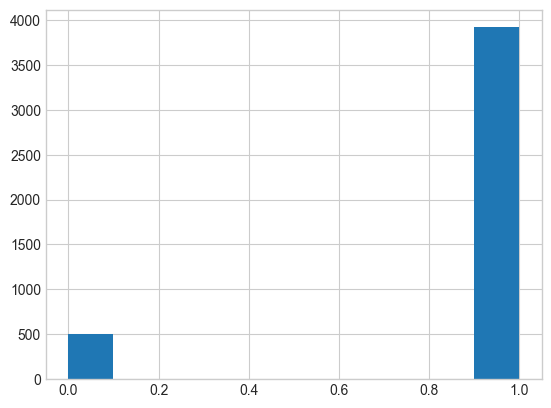

In [25]:
df['is_single'] = (df['marital_status'] == 1).astype(int) 

# Verificar print("Distribución de is_single:") 
print(df['is_single'].value_counts())
print(f"\nTasa deserción solteros (1): {df[df['is_single']==1]['target'].eq('Dropout').mean()*100:.1f}%") 
print(f"Tasa deserción no solteros (0): {df[df['is_single']==0]['target'].eq('Dropout').mean()*100:.1f}%") 

df['is_single'].hist()

La variable marital_status fue binarizada (Soltero vs No Soltero) debido a la presencia de categorías con muy pocos casos (Viudo: 4, Separado: 6) y al patrón claro observado: los estudiantes no solteros presentan una tasa de deserción del 47% frente al 30% de los solteros, probablemente debido a mayores responsabilidades familiares y laborales."

### 21.1.2 Variable aplication_mode

application_mode_risk
Bajo_Riesgo     2913
Alto_Riesgo     1006
Riesgo_Medio     505
Name: count, dtype: int64

Tasa de deserción por grupo:
application_mode_risk
Alto_Riesgo     55.47
Bajo_Riesgo     23.34
Riesgo_Medio    36.24
Name: target, dtype: float64


<Axes: >

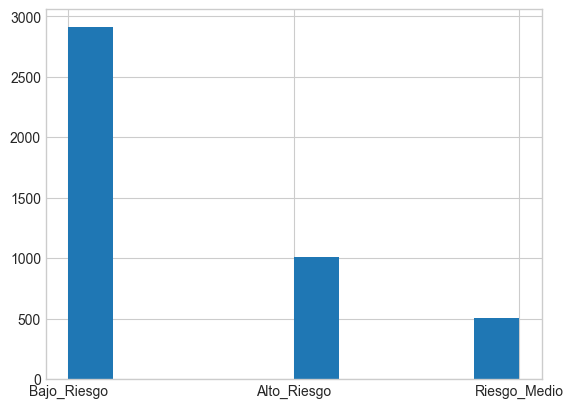

In [26]:
# Se agrupa en 3 categoria por nivel de riesgo
def agrupar_application_mode(x):
    # ALTO RIESGO (>40% deserción)
    if x in [39, 7, 42, 2, 26, 27]:
        return 'Alto_Riesgo'
    
    # RIESGO MEDIO (30-40% deserción)
    elif x in [43, 18, 51, 10]:
        return 'Riesgo_Medio'
    
    # BAJO RIESGO (<30% deserción)
    else:  # 1, 17, 44, 15, 16, 5, 53, 57
        return 'Bajo_Riesgo'

df['application_mode_risk'] = df['application_mode'].apply(agrupar_application_mode)

# Verificar
print(df['application_mode_risk'].value_counts())
print("\nTasa de deserción por grupo:")
print(df.groupby('application_mode_risk')['target'].apply(lambda x: (x == 'Dropout').mean() * 100).round(2))


df['application_mode_risk'].hist()


In [27]:
"""
HALLAZGO: "Los estudiantes que ingresan por la vía 'Mayor de 23 años' (código 39) presentan una tasa de deserción del 55.4%, casi triple que los estudiantes 
de 1ra fase general (20.2%). Este grupo representa el 17.7% del dataset (785 estudiantes) y constituye uno de los factores de riesgo más importantes identificado. 
Posible explicación: estudiantes adultos con responsabilidades laborales y familiares que dificultan la dedicación al estudio."**

# Variable binaria específica para "Mayor de 23"
df['is_over_23_entry'] = (df['application_mode'] == 39).astype(int) 

print(df['is_over_23_entry'].value_counts())
print("\nTasa de deserción is_over_23_entry:")
print(df.groupby('is_over_23_entry')['target'].apply(lambda x: (x=='Dropout').mean()*100).round(2))


"""

'\nHALLAZGO: "Los estudiantes que ingresan por la vía \'Mayor de 23 años\' (código 39) presentan una tasa de deserción del 55.4%, casi triple que los estudiantes \nde 1ra fase general (20.2%). Este grupo representa el 17.7% del dataset (785 estudiantes) y constituye uno de los factores de riesgo más importantes identificado. \nPosible explicación: estudiantes adultos con responsabilidades laborales y familiares que dificultan la dedicación al estudio."**\n\n# Variable binaria específica para "Mayor de 23"\ndf[\'is_over_23_entry\'] = (df[\'application_mode\'] == 39).astype(int) \n\nprint(df[\'is_over_23_entry\'].value_counts())\nprint("\nTasa de deserción is_over_23_entry:")\nprint(df.groupby(\'is_over_23_entry\')[\'target\'].apply(lambda x: (x==\'Dropout\').mean()*100).round(2))\n\n\n'

### 1.1.3 Variable course

In [28]:
### REVISAR ####
# =============================================================================
# 3. COURSE → Target Encoding (No se aplicará aqui, sino en modelado)
# =============================================================================
# NOTA: Se aplica SOLO en train para evitar data leakage
# from category_encoders import TargetEncoder
# te = TargetEncoder(cols=['course'], smoothing=0.3)
# df['course_encoded'] = te.fit_transform(df['course'], y)

### 1.1.4 Variable previous_qualification

<Axes: >

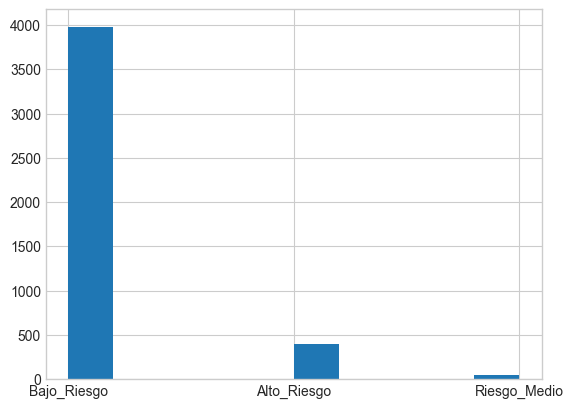

In [29]:
# Se agrupa en 3 categoria por nivel de riesgo
def agrupar_previous_qualification_riesgo(x):
    # ALTO RIESGO: Incompleta + Ed. superior previa
    if x in [9, 10, 14, 15, 2, 3, 19, 12, 5, 4, 6]:
        return 'Alto_Riesgo'
    # RIESGO MEDIO
    elif x in [38, 40]:
        return 'Riesgo_Medio'
    # BAJO RIESGO: Secundaria, técnicos
    else:
        return 'Bajo_Riesgo'

df['previous_qualification_risk'] = df['previous_qualification'].apply(agrupar_previous_qualification_riesgo)
df['previous_qualification_risk'].hist()



### 1.1.5 Variable nationality - SE EXCLUYE DEL MODELO - VARIABLE INTERNATIONAL YA CAPTURA A ESTUDIANTES EXTRANJEROS

### 1.1.6 Variable mothers_qualification y fathers_qualification

<Axes: >

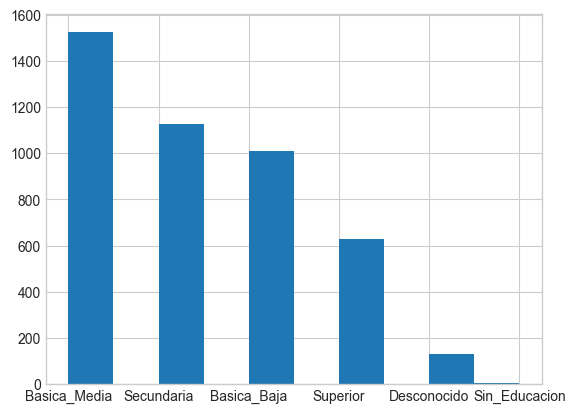

In [30]:
def agrupar_parent_qualification(x):
    if x == 34:
        return 'Desconocido'
    elif x in [35, 36, 20, 13, 25, 33, 31]:
        return 'Sin_Educacion'
    elif x == 37:
        return 'Basica_Baja'
    elif x in [38, 19, 11, 30, 26, 29]:
        return 'Basica_Media'
    elif x in [1, 12, 9, 10, 14, 15, 18, 22, 27]:
        return 'Secundaria'
    elif x in [2, 3, 4, 5, 6, 39, 40, 41, 42, 43, 44]:
        return 'Superior'
    else:
        return 'Desconocido'

df['mothers_qualification_level'] = df['mothers_qualification'].apply(agrupar_parent_qualification)
df['fathers_qualification_level'] = df['fathers_qualification'].apply(agrupar_parent_qualification)

df['mothers_qualification_level'].hist()


<Axes: >

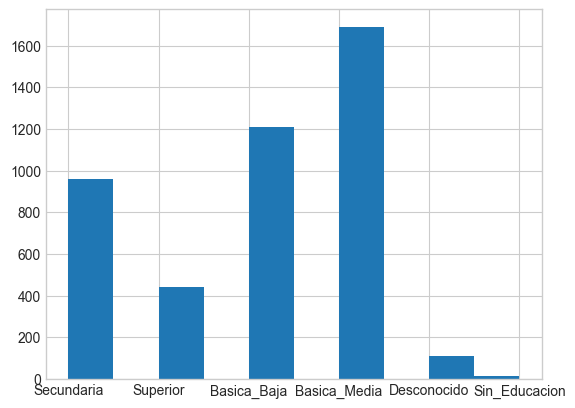

In [9]:
df['fathers_qualification_level'].hist()

### 1.1.7 Variable mothers_occupation y fathers_occupation

<Axes: >

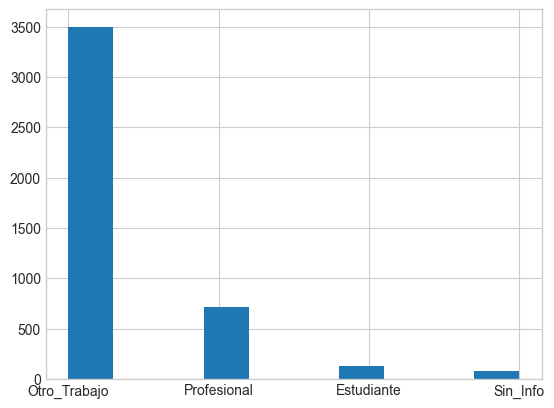

In [31]:
def agrupar_parent_occupation(x):
    if x in [90, 99]:
        return 'Sin_Info'
    elif x == 0:
        return 'Estudiante'
    elif x in [1, 2, 3]:
        return 'Profesional'
    else:
        return 'Otro_Trabajo'

df['mothers_occupation_level'] = df['mothers_occupation'].apply(agrupar_parent_occupation)
df['fathers_occupation_level'] = df['fathers_occupation'].apply(agrupar_parent_occupation)

df['fathers_occupation_level'].hist()

<Axes: >

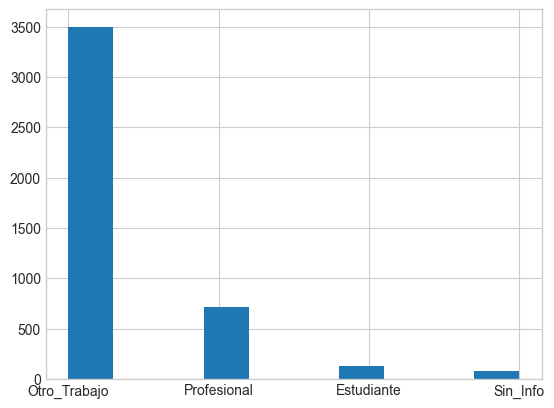

In [32]:
df['fathers_occupation_level'].hist()

### 1.1.8 FEATURE DERIVADA has_unknown_parent_info

In [33]:
""" Esta variable se crea por razones: 
1-. Cuando la variable mothers_qualification y/o fathers_qualification tienen código 34 ('Desconocio', es decir, no se tiene información del padre o madre) la tasa de deserción está sobre el 70% er bamos casos.
2-. Cuando la variable mothers_occupation y/o fathers_occupation tienen código 90 ('Otra situación', es decir, no categorizado para el padre o madre), 99 (Descripción en blanco) o 0 (Estudiante) la tasa de deserción 
está entre el 64% y 77% en ambos casos.



df['has_unknown_parent_info'] = (
    (df['mothers_qualification'] == 34) | 
    (df['fathers_qualification'] == 34) |
    (df['mothers_occupation'].isin([90, 99, 0])) |
    (df['fathers_occupation'].isin([90, 99, 0]))
).astype(int)
print(df['has_unknown_parent_info'].value_counts())
print("\nTasa de deserción:")
print(df.groupby('has_unknown_parent_info')['target'].apply(lambda x: (x=='Dropout').mean()*100).round(2))
"""

' Esta variable se crea por razones: \n1-. Cuando la variable mothers_qualification y/o fathers_qualification tienen código 34 (\'Desconocio\', es decir, no se tiene información del padre o madre) la tasa de deserción está sobre el 70% er bamos casos.\n2-. Cuando la variable mothers_occupation y/o fathers_occupation tienen código 90 (\'Otra situación\', es decir, no categorizado para el padre o madre), 99 (Descripción en blanco) o 0 (Estudiante) la tasa de deserción \nestá entre el 64% y 77% en ambos casos.\n\n\n\ndf[\'has_unknown_parent_info\'] = (\n    (df[\'mothers_qualification\'] == 34) | \n    (df[\'fathers_qualification\'] == 34) |\n    (df[\'mothers_occupation\'].isin([90, 99, 0])) |\n    (df[\'fathers_occupation\'].isin([90, 99, 0]))\n).astype(int)\nprint(df[\'has_unknown_parent_info\'].value_counts())\nprint("\nTasa de deserción:")\nprint(df.groupby(\'has_unknown_parent_info\')[\'target\'].apply(lambda x: (x==\'Dropout\').mean()*100).round(2))\n'

In [34]:
"""# Opción A: Flag de Alto Riesgo Financiero (Binaria)
# Lógica: Si es Deudor (1) Y NO tiene Beca (0) -> Riesgo (1)
df['financial_risk_flag'] = ((df['debtor'] == 1) & (df['scholarship_holder'] == 0)).astype(int)

# Verificación rápida
print("Distribución de Riesgo Financiero:")
print(df['financial_risk_flag'].value_counts())

# Validar impacto en la deserción (Target)
print("\nTasa de deserción por grupo de riesgo:")
print(df.groupby('financial_risk_flag')['target'].apply(lambda x: (x=='Dropout').mean()).round(3))
"""

'# Opción A: Flag de Alto Riesgo Financiero (Binaria)\n# Lógica: Si es Deudor (1) Y NO tiene Beca (0) -> Riesgo (1)\ndf[\'financial_risk_flag\'] = ((df[\'debtor\'] == 1) & (df[\'scholarship_holder\'] == 0)).astype(int)\n\n# Verificación rápida\nprint("Distribución de Riesgo Financiero:")\nprint(df[\'financial_risk_flag\'].value_counts())\n\n# Validar impacto en la deserción (Target)\nprint("\nTasa de deserción por grupo de riesgo:")\nprint(df.groupby(\'financial_risk_flag\')[\'target\'].apply(lambda x: (x==\'Dropout\').mean()).round(3))\n'

In [35]:
df['early_academic_failure_flag'] = (
    (df['curricular_units_1st_sem_enrolled'] > 0) &
    (df['curricular_units_1st_sem_approved'] == 0)
).astype(int)

In [ ]:
df['financial_pressure_score'] = ( df['debtor'] + (1 - df['scholarship_holder']) + (1 - df['tuition_fees_up_to_date']) )

In [ ]:
df['financial_academic_crisis_flag'] = ( (df['financial_pressure_score'] >= 2) & (df['early_academic_failure_flag'] == 1) ).astype(int)

In [ ]:
variables_a_eliminar = ["financial_pressure_score", "early_academic_failure_flag"]

# Eliminar solo si existen en el dataframe
df = df.drop(columns=[c for c in variables_a_eliminar if c in df.columns])

In [38]:
df.head(5)

,marital_status,application_mode,application_order,course,daytimeevening_attendance,previous_qualification,previous_qualification_grade,nacionality,mothers_qualification,fathers_qualification,...,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,early_academic_failure_flag,financial_pressure_score,financial_academic_crisis_flag
0,1,17,5,171,1,1,122.0,1,19,12,...,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,0,1,0
1,1,15,1,9254,1,1,160.0,1,1,3,...,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0,2,0
2,1,1,5,9070,1,1,122.0,1,37,37,...,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1,2,1
3,1,17,2,9773,1,1,122.0,1,38,37,...,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0,1,0
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0,1,0


# 2. TARGET BINARIO

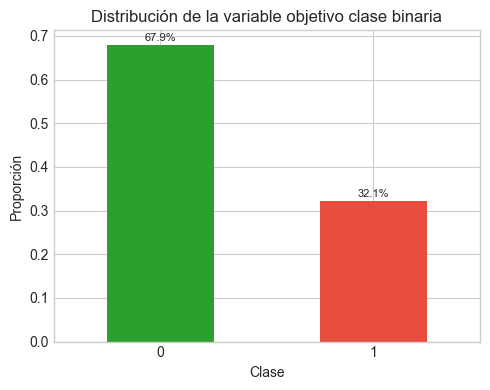

In [16]:
# =============================================================================
# PASO 1: Crear variable target binaria
# =============================================================================
df['target_binario'] = (df['target'] == 'Dropout').astype(int)
# 1 = Dropout, 0 = No Dropout (Graduate + Enrolled)

# -----------------------------------------------------------------------------
# Cálculo de proporciones
# -----------------------------------------------------------------------------
prop = df['target_binario'].value_counts(normalize=True).sort_index()

# Calculo y gráfica del "desbalance" luego del establecimienot del target binario
plt.figure(figsize=(5, 4))   

ax = prop.plot(
    kind='bar',
    color=['#2ca02c', '#E74C3C']
)

df['target_binario'].value_counts(normalize=True).plot(
    kind='bar',
    color=['#2ca02c', '#E74C3C']
)

# Agregar etiquetas de porcentaje sobre las barras
for i, v in enumerate(prop.values):
    ax.text(
        i,
        v + 0.01,
        f"{v:.1%}",
        ha='center',
        fontsize=8
    )


OUTPUT_DIR = "../outputs/figures/preprocesamiento/"
os.makedirs(OUTPUT_DIR, exist_ok=True)
# Nombre archivo 
filename = f"01_distribucion_target_binario.png"
filepath = os.path.join(OUTPUT_DIR, filename)

plt.title("Distribución de la variable objetivo clase binaria", fontsize=12)
plt.xlabel("Clase", fontsize=10)
plt.ylabel("Proporción", fontsize=10)
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()





In [17]:
# Conteo absoluto
counts = df['target_binario'].value_counts().sort_index()

# Proporción
props = df['target_binario'].value_counts(normalize=True).sort_index()

# Construir tabla final
tabla_desbalance = pd.DataFrame({
    "clase": counts.index,
    "cantidad": counts.values,
    "proporción": props.values
})

# Formato de porcentaje
tabla_desbalance["proporción"] = tabla_desbalance["proporción"].apply(lambda x: f"{x:.2%}")

tabla_desbalance

,clase,cantidad,proporción
0,0,3003,67.88%
1,1,1421,32.12%


# 3.0 ELIMINAR VARIABLES 

In [18]:

# Se eliminan debido a que se creo variable de agrupación
# VARIABLES: marital_status, application_mode, previous_qualification, mothers_qualification, fathers_qualification, mothers_occupation, fathers_occupation

# Se elimina target ya que de deja como binario
# VARIABLE: target

# Se elimina debido a que no es un buen predictor, el 99% de los estudiantes es de Portugal
# VARIABLE: nacionality

variables_a_eliminar = [
    "marital_status",
    "application_mode",
    "previous_qualification",
    "mothers_qualification",
    "fathers_qualification",
    "mothers_occupation",
    "fathers_occupation",
    "nacionality",
    "target"
]

# Eliminar solo si existen en el dataframe
df = df.drop(columns=[c for c in variables_a_eliminar if c in df.columns])

print("Columnas eliminadas del dataset:")
print([c for c in variables_a_eliminar if c not in df.columns])

Columnas eliminadas del dataset:
['marital_status', 'application_mode', 'previous_qualification', 'mothers_qualification', 'fathers_qualification', 'mothers_occupation', 'fathers_occupation', 'nacionality', 'target']


In [19]:
print("Preprocesamiento de variables categóricas completado")

Preprocesamiento de variables categóricas completado


# 4. VERIFICACIÓN FINAL DEL DATASET PROCESADO

In [20]:
# -----------------------------------------------------------------------------
# 6.1 Dimensiones
# -----------------------------------------------------------------------------
print(f"\n DIMENSIONES:")
print(f"   • Filas: {df.shape[0]:,}")
print(f"   • Columnas: {df.shape[1]}")

# -----------------------------------------------------------------------------
# 6.2 Columnas finales
# -----------------------------------------------------------------------------
print(f"\n COLUMNAS FINALES ({df.shape[1]}):")
for i, col in enumerate(df.columns, 1):
    print(f"   {i:2d}. {col}")

# -----------------------------------------------------------------------------
# 6.3 Tipos de datos
# -----------------------------------------------------------------------------
print("\n TIPOS DE DATOS:")
print(df.dtypes.value_counts().to_string())

# -----------------------------------------------------------------------------
# 6.4 Missing values
# -----------------------------------------------------------------------------
missing_total = df.isnull().sum().sum()
print(f"\n VALORES FALTANTES: {missing_total}")
if missing_total > 0:
    print(" Hay valores faltantes")
    print(df.isnull().sum()[df.isnull().sum() > 0])
else:
    print(" No hay valores faltantes")

# -----------------------------------------------------------------------------
# 6.5 Target binario
# -----------------------------------------------------------------------------
print("\n TARGET BINARIO:")
print(df['target_binario'].value_counts().to_string())
ratio = df['target_binario'].value_counts()[0] / df['target_binario'].value_counts()[1]
print(f"\n   Ratio (No Desertor / Desertor): {ratio:.2f}:1")
print(f"   Desbalance: {'Moderado' if ratio < 3 else 'Alto'}")

# -----------------------------------------------------------------------------
# 6.6 Variables por tipo
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("  RESUMEN DE VARIABLES POR TIPO")
print("="*70)

# Binarias (originales + derivadas)
vars_binarias_final = [
    'daytimeevening_attendance', 'displaced', 'educational_special_needs',
    'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 
    'international', 'is_single', 'is_over_23_entry', 'has_unknown_parent_info'
]
vars_binarias_en_df = [v for v in vars_binarias_final if v in df.columns]
print(f"\n BINARIAS ({len(vars_binarias_en_df)}):")
for v in vars_binarias_en_df:
    print(f"   • {v}: {df[v].unique()}")

# Categóricas agrupadas
vars_categoricas_agrupadas = [
    'application_mode_risk', 'previous_qualification_risk',
    'mothers_qualification_level', 'fathers_qualification_level',
    'mothers_occupation_level', 'fathers_occupation_level'
]
vars_cat_en_df = [v for v in vars_categoricas_agrupadas if v in df.columns]
print(f"\n CATEGÓRICAS AGRUPADAS ({len(vars_cat_en_df)}):")
for v in vars_cat_en_df:
    print(f"   • {v}: {df[v].nunique()} categorías → {df[v].unique().tolist()}")

# Categóricas sin agrupar (course, application_order)
vars_cat_sin_agrupar = ['course', 'application_order']
vars_cat_sin_en_df = [v for v in vars_cat_sin_agrupar if v in df.columns]
print(f"\n CATEGÓRICAS SIN AGRUPAR ({len(vars_cat_sin_en_df)}):")
for v in vars_cat_sin_en_df:
    print(f"   • {v}: {df[v].nunique()} valores únicos")

# Numéricas
vars_numericas = [
    'age_at_enrollment', 'admission_grade', 'previous_qualification_grade',
    'curricular_units_1st_sem_credited', 'curricular_units_1st_sem_enrolled',
    'curricular_units_1st_sem_evaluations', 'curricular_units_1st_sem_approved',
    'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations',
    'curricular_units_2nd_sem_credited', 'curricular_units_2nd_sem_enrolled',
    'curricular_units_2nd_sem_evaluations', 'curricular_units_2nd_sem_approved',
    'curricular_units_2nd_sem_grade', 'curricular_units_2nd_sem_without_evaluations',
    'unemployment_rate', 'inflation_rate', 'gdp'
]
vars_num_en_df = [v for v in vars_numericas if v in df.columns]
print(f"\n NUMÉRICAS ({len(vars_num_en_df)}):")
for v in vars_num_en_df:
    print(f"   • {v}")

# -----------------------------------------------------------------------------
# 6.7 Variables eliminadas
# -----------------------------------------------------------------------------
variables_eliminadas = [
    'marital_status', 'application_mode', 'previous_qualification',
    'mothers_qualification', 'fathers_qualification', 
    'mothers_occupation', 'fathers_occupation',
    'nacionality', 'target'
]
print(f"\n VARIABLES ELIMINADAS ({len(variables_eliminadas)}):")
for v in variables_eliminadas:
    print(f"   • {v}")

# -----------------------------------------------------------------------------
# 6.8 Resumen final
# -----------------------------------------------------------------------------
print("\n" + "="*70)
print("  RESUMEN FINAL")
print("="*70)

n_binarias = len(vars_binarias_en_df)
n_cat_agrupadas = len(vars_cat_en_df)
n_cat_sin_agrupar = len(vars_cat_sin_en_df)
n_numericas = len(vars_num_en_df)
n_target = 1

print(f"""
   Total variables: {df.shape[1]}
   
   Desglose:
   • Binarias:              {n_binarias}
   • Categóricas agrupadas: {n_cat_agrupadas}
   • Categóricas otras:     {n_cat_sin_agrupar}
   • Numéricas:             {n_numericas}
   • Target:                {n_target}
   ─────────────────────────
   Total:                   {n_binarias + n_cat_agrupadas + n_cat_sin_agrupar + n_numericas + n_target}
""")

# -----------------------------------------------------------------------------
# 6.9 Verificación de consistencia
# -----------------------------------------------------------------------------
print("="*70)
print("  VERIFICACIONES DE CONSISTENCIA")
print("="*70)

# Verificar que target_binario solo tiene 0 y 1
target_values = df['target_binario'].unique()
if set(target_values) == {0, 1}:
    print("\n Target_binario: Valores correctos (0, 1)")
else:
    print(f"\n Target_binario: Valores incorrectos {target_values}")

# Verificar que variables binarias solo tienen 0 y 1
print("\n Verificación de variables binarias:")
for v in vars_binarias_en_df:
    unique_vals = set(df[v].unique())
    if unique_vals <= {0, 1}:
        print(f" {v}: OK")
    else:
        print(f" {v}: Valores inesperados {unique_vals}")

# Verificar que no hay categorías inesperadas en agrupadas
print("\n Verificación de variables categóricas agrupadas:")
expected_categories = {
    'application_mode_risk': {'Alto_Riesgo', 'Riesgo_Medio', 'Bajo_Riesgo'},
    'previous_qualification_risk': {'Alto_Riesgo', 'Riesgo_Medio', 'Bajo_Riesgo'},
    'mothers_qualification_level': {'Desconocido', 'Sin_Educacion', 'Basica_Baja', 'Basica_Media', 'Secundaria', 'Superior'},
    'fathers_qualification_level': {'Desconocido', 'Sin_Educacion', 'Basica_Baja', 'Basica_Media', 'Secundaria', 'Superior'},
    'mothers_occupation_level': {'Sin_Info', 'Estudiante', 'Profesional', 'Otro_Trabajo'},
    'fathers_occupation_level': {'Sin_Info', 'Estudiante', 'Profesional', 'Otro_Trabajo'}
}

for v, expected in expected_categories.items():
    if v in df.columns:
        actual = set(df[v].unique())
        if actual <= expected:
            print(f" {v}: OK ({len(actual)} categorías)")
        else:
            unexpected = actual - expected
            print(f" {v}: Categorías inesperadas {unexpected}")

print("\n" + "="*70)
print(" VERIFICACIÓN COMPLETADA")
print("="*70)



 DIMENSIONES:
   • Filas: 4,424
   • Columnas: 37

 COLUMNAS FINALES (37):
    1. application_order
    2. course
    3. daytimeevening_attendance
    4. previous_qualification_grade
    5. admission_grade
    6. displaced
    7. educational_special_needs
    8. debtor
    9. tuition_fees_up_to_date
   10. gender
   11. scholarship_holder
   12. age_at_enrollment
   13. international
   14. curricular_units_1st_sem_credited
   15. curricular_units_1st_sem_enrolled
   16. curricular_units_1st_sem_evaluations
   17. curricular_units_1st_sem_approved
   18. curricular_units_1st_sem_grade
   19. curricular_units_1st_sem_without_evaluations
   20. curricular_units_2nd_sem_credited
   21. curricular_units_2nd_sem_enrolled
   22. curricular_units_2nd_sem_evaluations
   23. curricular_units_2nd_sem_approved
   24. curricular_units_2nd_sem_grade
   25. curricular_units_2nd_sem_without_evaluations
   26. unemployment_rate
   27. inflation_rate
   28. gdp
   29. is_single
   30. application_mode

In [21]:
df.head()

,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,...,gdp,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,early_academic_failure_flag,target_binario
0,5,171,1,122.0,127.3,1,0,0,1,1,...,1.74,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,0,1
1,1,9254,1,160.0,142.5,1,0,0,0,1,...,0.79,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0,0
2,5,9070,1,122.0,124.8,1,0,0,0,1,...,1.74,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1,1
3,2,9773,1,122.0,119.6,1,0,0,1,0,...,-3.12,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0,0
4,1,8014,0,100.0,141.5,0,0,0,1,0,...,0.79,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0,0


# 5.0 GUARDAR DF PROCESADO

In [22]:
output_path = "../data/processed/preprocessed_data.csv"
df.to_csv(output_path, index=False)
print(f"Dataset procesado guardado en: {output_path}")

df.head()



Dataset procesado guardado en: ../data/processed/preprocessed_data.csv


,application_order,course,daytimeevening_attendance,previous_qualification_grade,admission_grade,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,...,gdp,is_single,application_mode_risk,previous_qualification_risk,mothers_qualification_level,fathers_qualification_level,mothers_occupation_level,fathers_occupation_level,early_academic_failure_flag,target_binario
0,5,171,1,122.0,127.3,1,0,0,1,1,...,1.74,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Secundaria,Otro_Trabajo,Otro_Trabajo,0,1
1,1,9254,1,160.0,142.5,1,0,0,0,1,...,0.79,1,Bajo_Riesgo,Bajo_Riesgo,Secundaria,Superior,Profesional,Profesional,0,0
2,5,9070,1,122.0,124.8,1,0,0,0,1,...,1.74,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Baja,Otro_Trabajo,Otro_Trabajo,1,1
3,2,9773,1,122.0,119.6,1,0,0,1,0,...,-3.12,1,Bajo_Riesgo,Bajo_Riesgo,Basica_Media,Basica_Baja,Otro_Trabajo,Profesional,0,0
4,1,8014,0,100.0,141.5,0,0,0,1,0,...,0.79,0,Alto_Riesgo,Bajo_Riesgo,Basica_Baja,Basica_Media,Otro_Trabajo,Otro_Trabajo,0,0
